### AJ_0065.4 - Monocle 2 trajectory during reprogramming MEFs to iPSCs 

Importing the seurat object to Monocle 

### Run with conda env: R_scRNA_seq_XCR2

In [51]:
library(monocle)
library(Seurat)
library(M3Drop)
library(dplyr)
library(readr)
library(magrittr)
library(viridis)
library(tidyr)
library(tibble)
library(egg)

In [52]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /vsc-hard-mounts/leuven-data/320/vsc32023/miniconda/envs/R_scRNA_seq_XCR2/lib/R/lib/libRblas.so

locale:
[1] C

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] egg_0.4.5           gridExtra_2.3       tibble_2.1.1       
 [4] tidyr_0.8.3         viridis_0.5.1       viridisLite_0.3.0  
 [7] magrittr_1.5        readr_1.3.1         dplyr_0.8.0.1      
[10] M3Drop_1.10.0       numDeriv_2016.8-1   Seurat_3.0.2       
[13] monocle_2.14.0      DDRTree_0.1.5       irlba_2.3.3        
[16] VGAM_1.1-1          ggplot2_3.1.1       Biobase_2.46.0     
[19] BiocGenerics_0.32.0 Matrix_1.2-17      

loaded via a namespace (and not attached):
  [1] Rtsne_0.15           colorspace_1.4-1     ggridges_0.5.1      
  [4] htmlTable_1.13.1     I

In [53]:
setwd("/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2")

### Import function that imports seurat 3 object to monocle

*At the time, there was only Monocle2 and at the time, it couldn't import a new (at the time) seurat 3 object. So I used this function from the internet to import Seurat 3 object to Monocle 2*

In [54]:
#seurat_data <- newimport(SeuratObject)
###
newimport <- function(otherCDS, import_all = FALSE) {
  if(class(otherCDS)[1] == 'Seurat') {
    requireNamespace("Seurat")
    data <- otherCDS@assays$RNA@counts

    if(class(data) == "data.frame") {
      data <- as(as.matrix(data), "sparseMatrix")
    }

    pd <- tryCatch( {
      pd <- new("AnnotatedDataFrame", data = otherCDS@meta.data)
      pd
    }, 
    #warning = function(w) { },
    error = function(e) { 
      pData <- data.frame(cell_id = colnames(data), row.names = colnames(data))
      pd <- new("AnnotatedDataFrame", data = pData)

      message("This Seurat object doesn't provide any meta data");
      pd
    })

    # remove filtered cells from Seurat
    if(length(setdiff(colnames(data), rownames(pd))) > 0) {
      data <- data[, rownames(pd)]  
    }

    fData <- data.frame(gene_short_name = row.names(data), row.names = row.names(data))
    fd <- new("AnnotatedDataFrame", data = fData)
    lowerDetectionLimit <- 0

    if(all(data == floor(data))) {
      expressionFamily <- negbinomial.size()
    } else if(any(data < 0)){
      expressionFamily <- uninormal()
    } else {
      expressionFamily <- tobit()
    }

    valid_data <- data[, row.names(pd)]

    monocle_cds <- newCellDataSet(data,
                                  phenoData = pd, 
                                  featureData = fd,
                                  lowerDetectionLimit=lowerDetectionLimit,
                                  expressionFamily=expressionFamily)

    if(import_all) {
      if("Monocle" %in% names(otherCDS@misc)) {
        otherCDS@misc$Monocle@auxClusteringData$seurat <- NULL
        otherCDS@misc$Monocle@auxClusteringData$scran <- NULL

        monocle_cds <- otherCDS@misc$Monocle
        mist_list <- otherCDS

      } else {
        # mist_list <- list(ident = ident) 
        mist_list <- otherCDS
      }
    } else {
      mist_list <- list()
    }

    if(1==1) {
      var.genes <- setOrderingFilter(monocle_cds, otherCDS@assays$RNA@var.features)

    }
    monocle_cds@auxClusteringData$seurat <- mist_list

  } else if (class(otherCDS)[1] == 'SCESet') {
    requireNamespace("scater")

    message('Converting the exprs data in log scale back to original scale ...')    
    data <- 2^otherCDS@assayData$exprs - otherCDS@logExprsOffset

    fd <- otherCDS@featureData
    pd <- otherCDS@phenoData
    experimentData = otherCDS@experimentData
    if("is.expr" %in% slotNames(otherCDS))
      lowerDetectionLimit <- otherCDS@is.expr
    else 
      lowerDetectionLimit <- 1

    if(all(data == floor(data))) {
      expressionFamily <- negbinomial.size()
    } else if(any(data < 0)){
      expressionFamily <- uninormal()
    } else {
      expressionFamily <- tobit()
    }

    if(import_all) {
      # mist_list <- list(iotherCDS@sc3,
      #                   otherCDS@reducedDimension)
      mist_list <- otherCDS 

    } else {
      mist_list <- list()
    }

    monocle_cds <- newCellDataSet(data,
                                  phenoData = pd, 
                                  featureData = fd,
                                  lowerDetectionLimit=lowerDetectionLimit,
                                  expressionFamily=expressionFamily)
    # monocle_cds@auxClusteringData$sc3 <- otherCDS@sc3
    # monocle_cds@auxOrderingData$scran <- mist_list

    monocle_cds@auxOrderingData$scran <- mist_list

  } else {
    stop('the object type you want to export to is not supported yet')
  }

  return(monocle_cds)
}

In [55]:
seurat <- readRDS("seurat/seurat_clustering.rds")

In [56]:
# Import data from seurat object to monocle object 

monocle <- newimport(seurat)

Removing 304 outliers
Warning message:
"Transformation introduced infinite values in continuous y-axis"

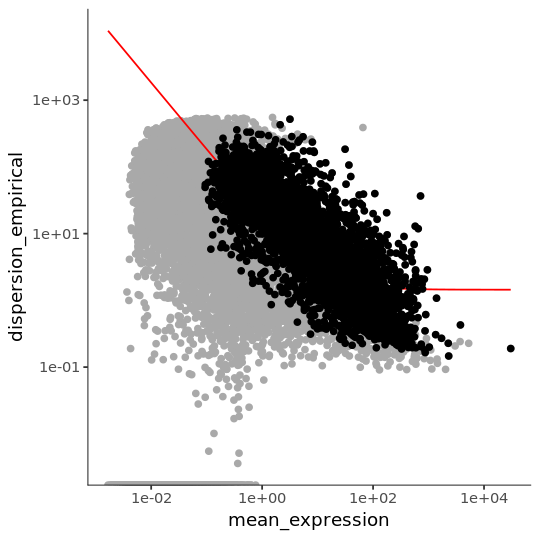

In [57]:
monocle <- estimateSizeFactors(monocle)
monocle <- estimateDispersions(monocle)

monocle <- detectGenes(monocle, min_expr = 0.1)

expressed_genes <- row.names(subset(fData(monocle),
    num_cells_expressed >= 10))

diff_test_res <- differentialGeneTest(monocle[expressed_genes,],
              fullModelFormulaStr = "~Timepoint")
ordering_genes <- row.names(subset(diff_test_res, qval < 0.01))

monocle <- setOrderingFilter(monocle, ordering_genes)
plot_ordering_genes(monocle)

monocle <- reduceDimension(monocle, max_components = 2,
    method = 'DDRTree')

monocle <- orderCells(monocle, reverse = TRUE)

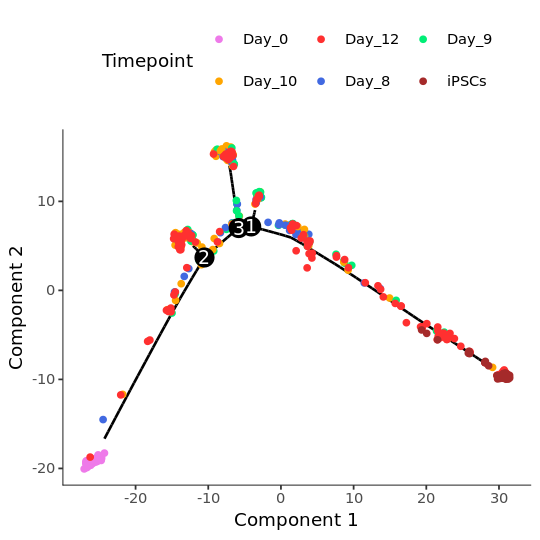

In [58]:
plot_cell_trajectory(monocle, color_by = "Timepoint")+
scale_colour_manual(values = c("orchid2","orange","firebrick1","royalblue","springgreen2","brown"))

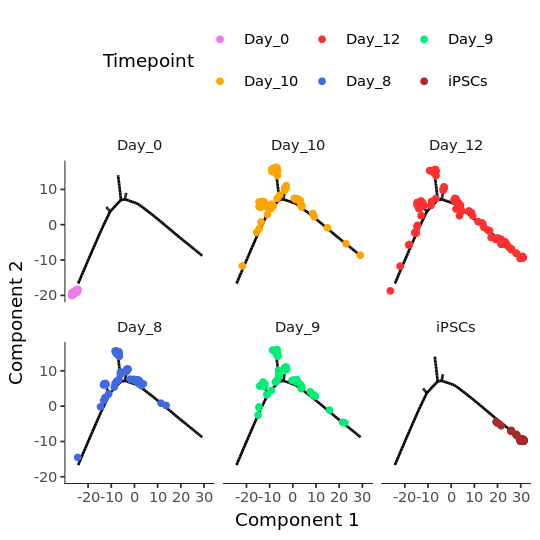

In [59]:
plot_cell_trajectory(monocle, color_by = "Timepoint", show_branch_points = FALSE) +
scale_colour_manual(values = c("orchid2","orange","firebrick1","royalblue","springgreen2","brown")) +
    facet_wrap(~Timepoint, nrow = 2)

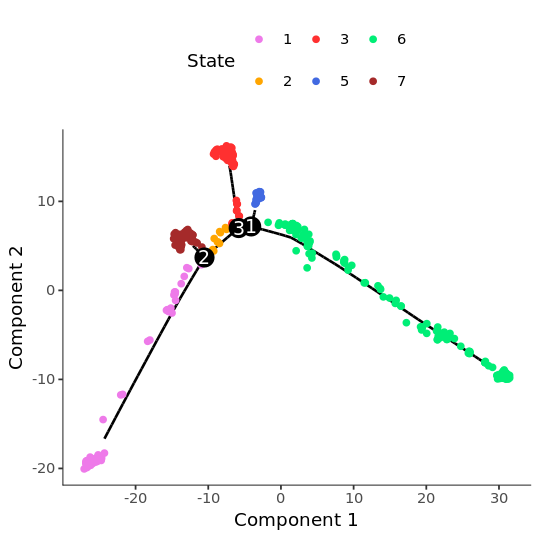

In [60]:
plot_cell_trajectory(monocle, color_by = "State")+
scale_colour_manual(values = c("orchid2","orange","firebrick1","royalblue","springgreen2","brown"))

#### Add pseudotime data to seurat object

In [13]:
monocle_phenoData <- data.frame(phenoData(monocle)@data) %>%
                        select(Name, Pseudotime, State)

In [13]:
seurat@meta.data <- seurat@meta.data %>% 
                            rownames_to_column("cell_id") %>%
                            left_join(monocle_phenoData, by = "Name") %>%
                            column_to_rownames("cell_id")

In [13]:
saveRDS(seurat, "monocle/seurat_pseudotime.rds")

In [37]:
seurat <- readRDS("monocle/seurat_pseudotime.rds")

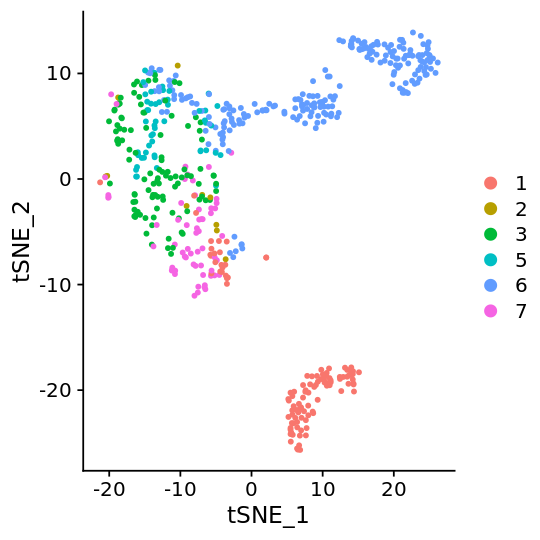

In [50]:
DimPlot(seurat, group.by = "State")

#### Plot pseudotime on tSNE

In [15]:
options(repr.plot.width=4.5, repr.plot.height=4.5)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


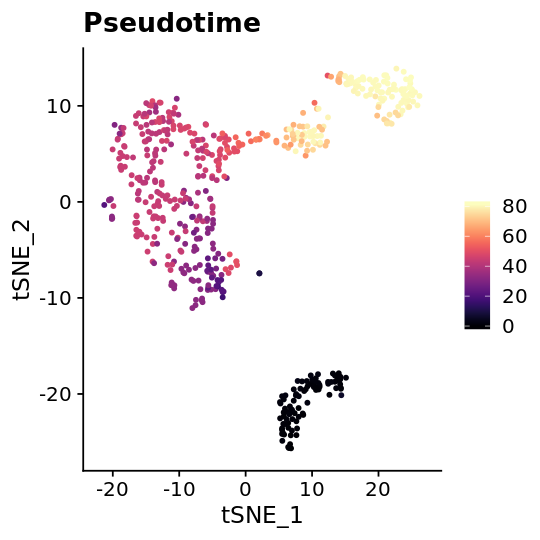

In [16]:
FeaturePlot(seurat, "Pseudotime" ) +
    scale_color_viridis(option = "A")

#### Export a table with normalized expression + clusters + pseudotime for easy plotting

In [61]:
expression <- seurat[["RNA"]]@data %>% 
                t() %>% 
                as.data.frame() %>%
                rownames_to_column("Name")
    
pseudotime <- seurat@meta.data %>%
                select(Name, Pseudotime, seurat_clusters_rename)
    
data_combined <- expression %>%
                    left_join(pseudotime, by = "Name") %>%
                    gather(gene, expression, -Name, -Pseudotime, -seurat_clusters_rename)

In [63]:
#write.csv(data_combined, "monocle/pseudotime_cluster_gene_normExpr.csv")

In [3]:
#data_combined <- read_csv("monocle/pseudotime_cluster_gene_normExpr.csv")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_double(),
  Name = col_character(),
  Pseudotime = col_double(),
  seurat_clusters_rename = col_double(),
  gene = col_character(),
  expression = col_double()
)


#### Plot gene expression as a function of pseudotime

In [31]:
plot_expression_vs_pseudotime <- function(data_combined, genes, title = "Pluripotency") {
    
    # Takes a long table with variables: gene, expression, Pseudotime
    # Plots normalized log transformed gene expression as a function of pseudotime for selected genes
    # param: genes = vector containing a set of genes to plot 
    
    plot <- data_combined %>% 
                filter(gene %in% genes) %>%
                ggplot(aes(Pseudotime, expression, color = gene)) +
                             geom_smooth( size = .7, alpha = .10) +                                                     
                                    ylab("Normalized expression")+
                                    ggtitle(title) +
                                    #scale_color_brewer(palette="Set1")+
                                    theme_classic() 
    
    return(plot)
    
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


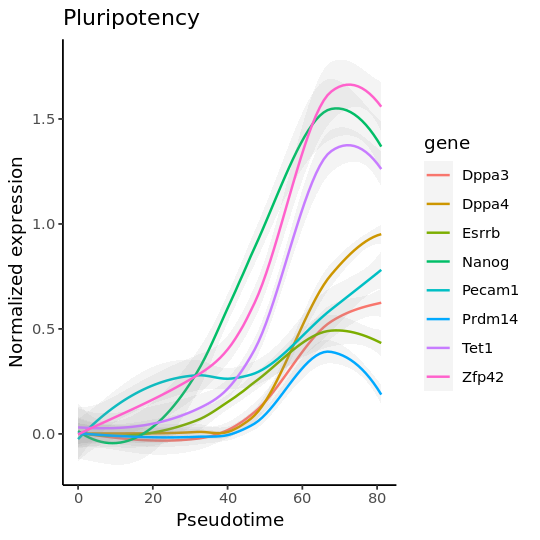

In [32]:
genes <- c("Nanog", "Dppa4", "Dppa3","Pecam1", "Tet1", "Zfp42", "Prdm14", "Esrrb")

plot_expression_vs_pseudotime(data_combined, genes)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


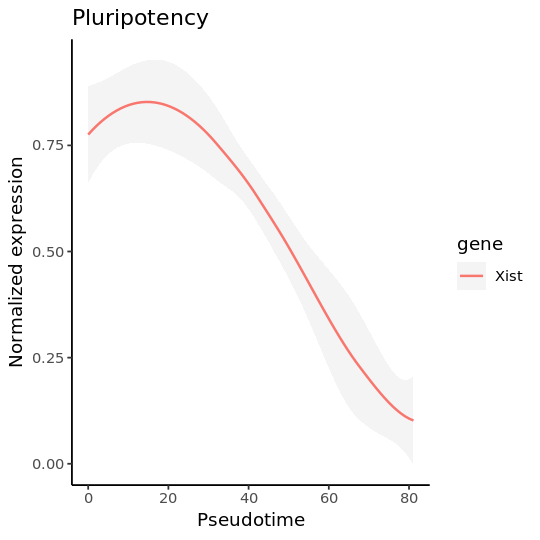

In [33]:
genes <- c("Xist")

plot_expression_vs_pseudotime(data_combined, genes, title = "Xist expression")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


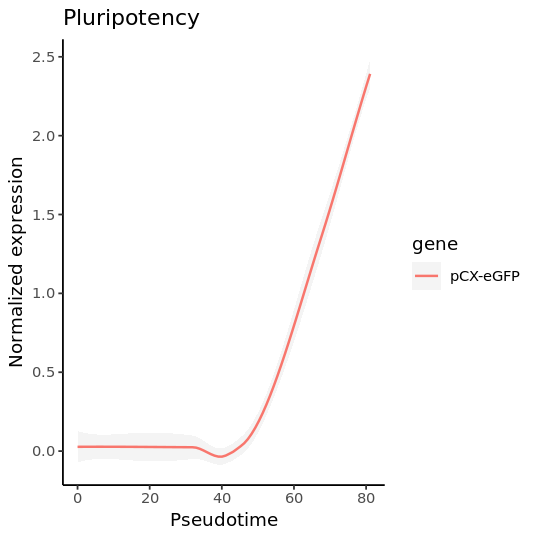

In [34]:
genes <- c("pCX-eGFP")

plot_expression_vs_pseudotime(data_combined, genes, title = "X-GFP expression")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


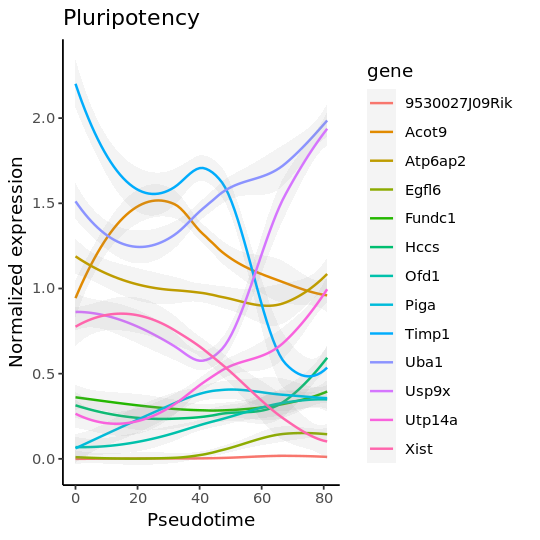

In [35]:
genes <- c("Uba1", "Usp9x", "Egfl6", "Hccs", "9530027J09Rik", "Atp6ap2", 
           "Timp1", "Acot9", "Ofd1", "Utp14a", "Fundc1", "Piga", "Xist")

plot_expression_vs_pseudotime(data_combined, genes)

### Plot heatmap of genes organized by clusters and ordered by pseudotime within each cluster

In [5]:
# Signatures contain selected genes from signatures defined and published in Schiebinger et al., 2019

gene_signatures <- c('Vim','Ccdc80','Maged2','Cdkn2b', # MEF identity
                     'Tgm1', 'Cldn3','Cdh1','Cldn4','Epcam',# Epithelial indentity
                     #'Sct','H19','Rhox6','Ldoc1','Krt7','Plac1','Krt8','Krt19','Krt18', # Trophoblast identity
                     #'Gbp2','Gbp3','Gbp7','Oasl2','Isg15', # Reprogramming progenitor # Guo
                     #'Ascl1','Sox11','Map1b','Nrp2','Serpine2','Tcf12', # Neural identity # Guo
                     #'Cdh2','Sox1','Msx1','Pax6','Sox2','Sox9','Hoxb1', # Neural identity 
                     'Nanog','Zfp42','Esrrb','Prdm14','Dppa4','Dppa5a', # Pluripotency identity
                     'Mcm4','Smc4','Top2a','Cdk1','Cenpa') # Proliferation identity
                     #'Ercc5','Serpinb5','Inhbb', # Apoptosis identity
                     # 'Nck2','Ankzf1','Dnajb2','Rhbdd1','Bcl2', # ER stress
                     #'Gata4','Gata6','Pdgfra', # XEN cells
                     #'Cdx2','Eomes') # TE 

**Import a function below by Dave Robinson that allows to order things within each facet (not available by deafult in ggplot)**  
no need to change anything in the function

In [6]:
#' Reorder an x or y axis within facets
#'
#' Reorder a column before plotting with faceting, such that the values are ordered
#' within each facet. This requires two functions: \code{reorder_within} applied to
#' the column, then either \code{scale_x_reordered} or \code{scale_y_reordered} added
#' to the plot.
#' This is implemented as a bit of a hack: it appends ___ and then the facet
#' at the end of each string.
#'
#' @param x Vector to reorder.
#' @param by Vector of the same length, to use for reordering.
#' @param within Vector of the same length that will later be used for faceting
#' @param fun Function to perform within each subset to determine the resulting
#' ordering. By default, mean.
#' @param sep Separator to distinguish the two. You may want to set this manually
#' if ___ can exist within one of your labels.
#' @param ... In \code{reorder_within} arguments passed on to \code{\link{reorder}}.
#' In the scale functions, extra arguments passed on to
#' \code{\link[ggplot2]{scale_x_discrete}} or \code{\link[ggplot2]{scale_y_discrete}}.
#'
#' @source "Ordering categories within ggplot2 Facets" by Tyler Rinker:
#' \url{https://trinkerrstuff.wordpress.com/2016/12/23/ordering-categories-within-ggplot2-facets/}
#'
#' @examples
#'
#' library(tidyr)
#' library(ggplot2)
#'
#' iris_gathered <- gather(iris, metric, value, -Species)
#'
#' # reordering doesn't work within each facet (see Sepal.Width):
#' ggplot(iris_gathered, aes(reorder(Species, value), value)) +
#'   geom_boxplot() +
#'   facet_wrap(~ metric)
#'
#' # reorder_within and scale_x_reordered work.
#' # (Note that you need to set scales = "free_x" in the facet)
#' ggplot(iris_gathered, aes(reorder_within(Species, value, metric), value)) +
#'   geom_boxplot() +
#'   scale_x_reordered() +
#'   facet_wrap(~ metric, scales = "free_x")
#'
#' @export
reorder_within <- function(x, by, within, fun = mean, sep = "___", ...) {
  new_x <- paste(x, within, sep = sep)
  stats::reorder(new_x, by, FUN = fun)
}


#' @rdname reorder_within
#' @export
scale_x_reordered <- function(..., sep = "___") {
  reg <- paste0(sep, ".+$")
  ggplot2::scale_x_discrete(labels = function(x) gsub(reg, "", x), ...)
}


#' @rdname reorder_within
#' @export
scale_y_reordered <- function(..., sep = "___") {
  reg <- paste0(sep, ".+$")
  ggplot2::scale_y_discrete(labels = function(x) gsub(reg, "", x), ...)
}

In [7]:
heatmap_data <- data_combined %>% 
                    filter(gene %in% gene_signatures) %>%
                    mutate(Name = as.factor(Name),
                    Name = reorder_within(Name, (Pseudotime)*-1, seurat_clusters_rename)) %>%
                    mutate(gene = factor(.$gene, levels = gene_signatures))

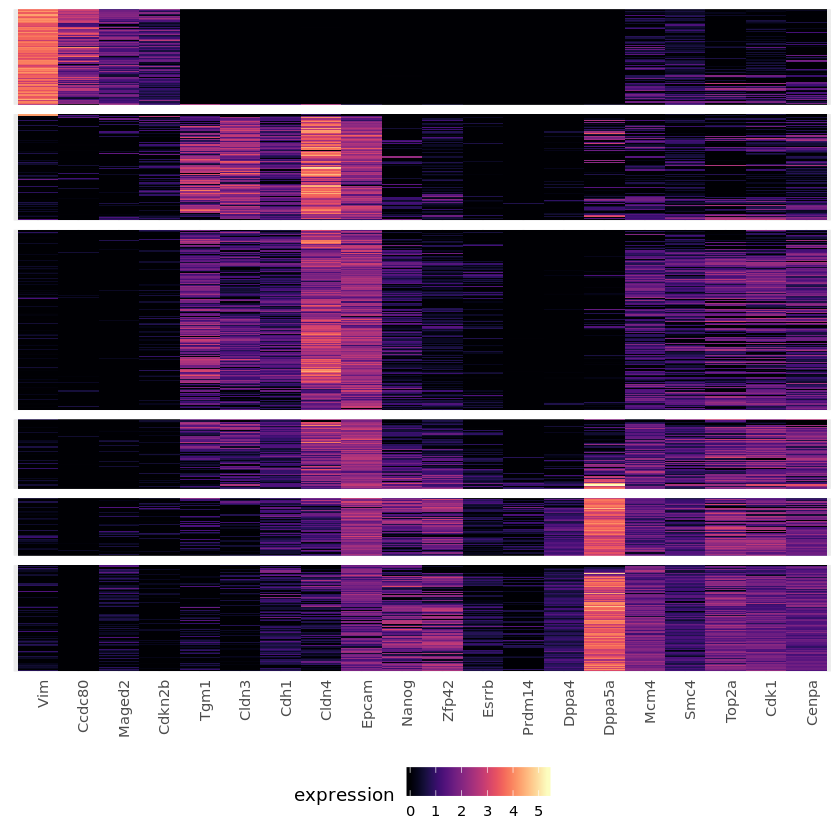

In [8]:
hm <- ggplot(heatmap_data, aes(x=gene,y=Name, fill = expression))+
        geom_tile()+
        scale_fill_viridis(option = 'A')+
        scale_y_reordered() +
        facet_grid(seurat_clusters_rename ~ ., scales = 'free', space = 'free_y') +
        theme_minimal() +
        theme(legend.position = "bottom") +
        theme(axis.text.y=element_blank()) +
        theme(strip.background = element_blank(),
          strip.text.y = element_blank()) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        theme(axis.title.x = element_blank()) +
        theme(axis.title.y = element_blank())
hm

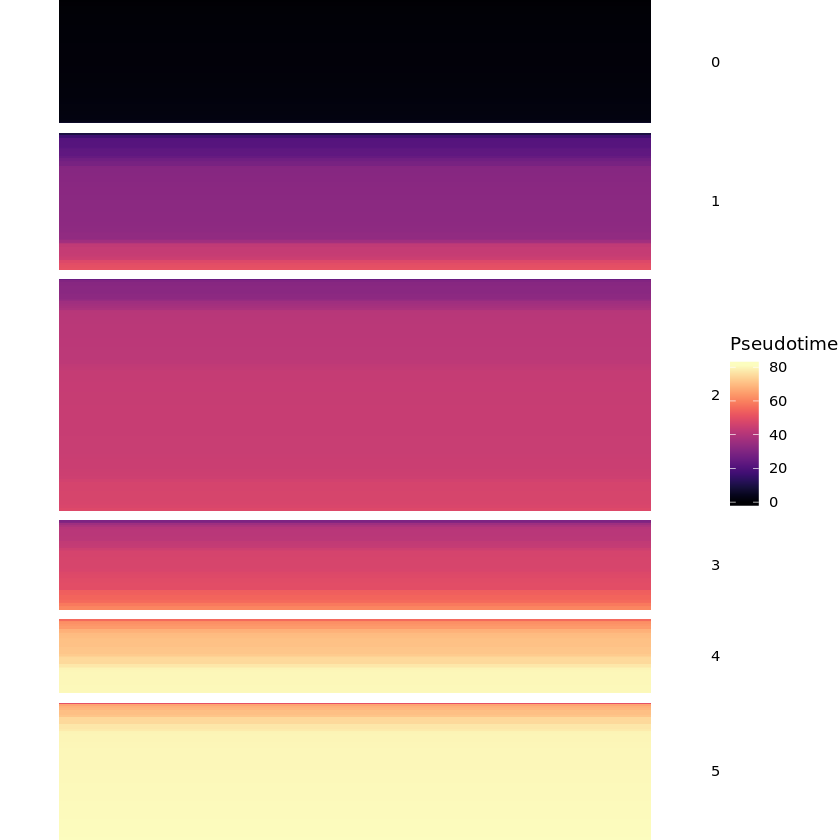

In [9]:
pt <- ggplot(heatmap_data, aes(x='pseudotime',y=Name, fill = Pseudotime))+
        geom_tile()+
        scale_fill_viridis(option = 'A')+
        scale_y_reordered()+
        facet_grid(seurat_clusters_rename ~ ., scales = 'free', space = 'free_y') +
        theme_void() +
        theme(legend.position = "right")+
        theme(axis.text.y=element_blank()) +
        theme(strip.background = element_blank(),
          strip.text.x = element_blank())
pt

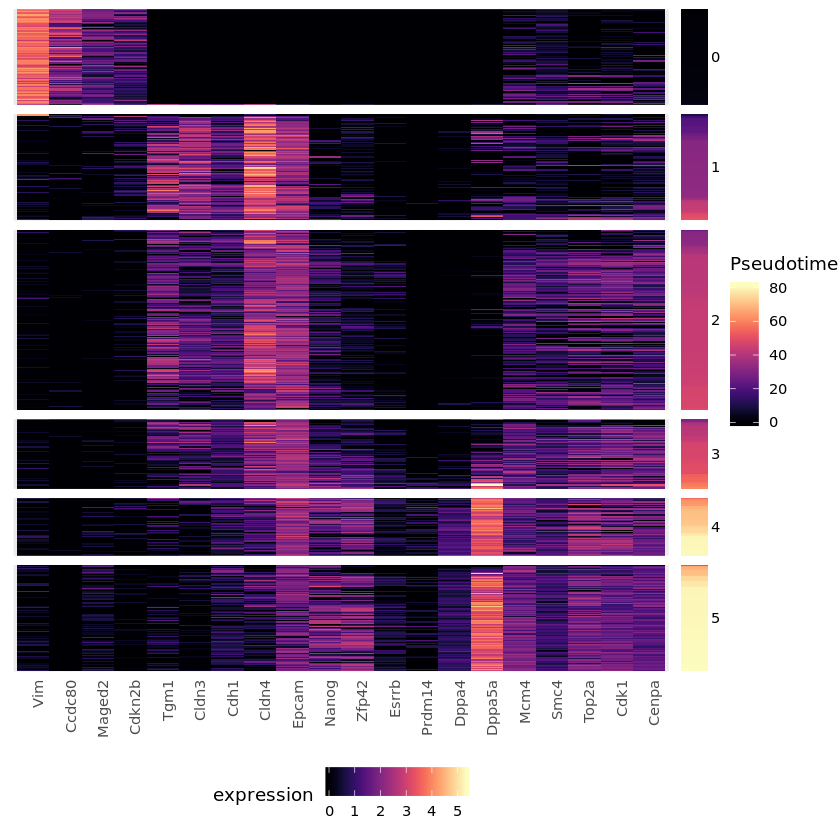

In [12]:
markers_sel_pseudo <- ggarrange(
                          hm, pt, 
                          nrow = 1, ncol = 2, widths = c(20,1)
                        )

# In the figure I re-organized gene signatures manually in the Illustrator (¯\_(ツ)_/¯) 

In [ ]:
#pdf('markers_sel_pseudo.pdf', useDingbats = FALSE, height = 3.8, width = 4)
#plot(markers_sel_pseudo)
#dev.off()